A python function that computes the expected SN of a detection. Core function to be called in the monte carlo routine.

STEPS OF THE CODE:

1) compute the background level for a given exposure time. To get the code up and running for now. Just fix the background level here for now. I asked Kevin about computing the background in a given medium band filter. He did not think it would be too difficult. You compute the number of background photons given lw. Then assume poisson noise for the background. That gives the noise. There is one aspect to be careful here is that to make the postage stamp you want to know the number of background photons per pixel. Kevin can help us more here.

2) compute the flux of the galaxy in this mediaum band (given by z=> central wavelength and by lw)

3) generate a postage stamp for this galaxy, Make sure that the size of the galaxy scales with the redshift assumed Make a postage stamp that scales with the size of the galaxy (use 5 times the size of the galaxy?)

4) We assume that we know the centroid of the galaxy (forced photometry) Compute aperture flux. Run SEP. question: what aperture to use here? Use one that is matched to the size of the galaxy?

5) now we want to compute the error on the detected flux.

6) compute the predicted flux in this medium band filter WITHOUT the emission line.

7) Compute the SN (flux-broadbandflux)/sigma of the "detection" where "detection" is the fluz in 4) ABOVE the background level.

7) return the SN of the detection (not of the detected flux, this is of the detected flux above he broadband level)

NOTE: keep note that in the future, we should include the error on the broadband flux

RETURNS : detected signal to noise of the emission line

In [1]:
import os
import numpy as np
from scipy.interpolate import interp1d

import galsim
import astropy
import astropy.units as units
import cosmology
import sep
import fitsio

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
%matplotlib inline

In [23]:
#Here are the inputs
#which filter to use (0 for nb, 1 for SDSS_r)
filter_number = 0
#redshift (central wavelength is computed from z)
redshift = 0.15
#filter center
wave_cen = 6564*(1+redshift) #AA
#filter width
filter_width = 200 #AA
#texp : exposure time
exptime = 3600# sec
#log stellar mass
M_star = 8.5
#size : galaxy size
gal_r50 = 0.5 #arcsec
#SED model number (0-3999)
SED_model = 2000

#telescope diameter in meter
d_telescope = 8.2 #HSC
#Collecting area of telescope in cm^2
area = np.pi*(d_telescope/2*10**2)**2
#pizelsize : fix for now to 0.18"
pixel_scale = 0.18 # arcsec/pixel
#image size
length = 64 #pixels
#psf: which PSF to assume
psf = 1 #PSF TYPE
#set cosmology
cosmo = cosmology.Cosmo(H0=70, omega_m = 0.3)
dl = cosmo.Dl(0.0,redshift)*10**6 #distance luminosity in pc

# Useful constants
lsun = 3.846e33  # erg/s
pc = 3.085677581467192e18  # in cm
lightspeed = 2.998e18  # AA/s
ckms = 2.998e5  # km/s
jansky_mks = 1e-26
jansky_cgs = 1e-23
# value to go from L_sun/AA to erg/s/cm^2/AA at 10pc
to_cgs_at_10pc = lsun / (4.0 * np.pi * (pc*10)**2)
to_cgs_at_dl = lsun / (4.0 * np.pi * (pc*dl)**2)

#option: which line to use (Halpha, OIII)
#option: which profile to assume for dwarfs (e.g. exponential)

In [24]:
def compute_sn(redshift, wave_cen, filter_width, exptime, M_star, gal_r50, SED_model):
    
    datapath = "/Users/yifei/work/dwarf/computesn"

    # Initialize (pseudo-)random number generator
    random_seed = 1234567
    rng = galsim.BaseDeviate(random_seed)
    
    
    # Generate the artificial narrowband filter (nb) with sigmoid damping
    def _sigmoid(x):
        return 1. / (1. + np.exp(-x))
    peak_response=1.0
    wave_margin=10
    #if filter_width < 20:
    #    raise Exception("The filter should be at least 20 Anstrom wide.")
    half_width = int(filter_width / 2) + wave_margin
    wavelength = np.arange(half_width * 2) + wave_cen - half_width
    half_window = np.arange(half_width) - wave_margin
    response_curve = np.concatenate([_sigmoid(half_window), _sigmoid(half_window)[::-1]]) * peak_response
    filter_func = interp1d(wavelength, response_curve, kind=3)
    filter_nb = galsim.Bandpass(filter_func, wave_type='Ang',
                                blue_limit=min(wavelength), red_limit=max(wavelength)).withZeropoint(zeropoint='AB')
    
    
    # Read the broadband filters (here SDSS r-band)
    filter_filename = os.path.join(datapath, 'share/bandpasses/SDSS_r.dat')
    filter_r = galsim.Bandpass(filter_filename, wave_type='nm').withZeropoint(zeropoint='AB')
    filter_r = filter_r.thin(rel_err=1e-4)
    
    
    # Read in galaxy SEDs from fsps (with emission lines)
    dwarf_seds = np.load('dwarf_sample_gaussian_test.npy')
    dwarf_wave = dwarf_seds['wave'][SED_model]
    dwarf_em = dwarf_seds['spec_em'][SED_model] #with emission lines
    #convert spec_em (in Lsun/Ang) into erg/s/cm^2/Ang at dl
    dwarf_em = dwarf_em*to_cgs_at_dl#*exptime
    #spec_em is the spectra of a galaxy with stellar mass equal to dwarf_seds['mstar']
    #here convert it into M_star
    dwarf_em = dwarf_em/dwarf_seds['mstar'][SED_model]*10**M_star
    sed_func_em = interp1d(dwarf_wave, dwarf_em, kind=3)
    SED_dwarf_em = galsim.SED(sed_func_em, wave_type=units.AA, 
                           flux_type=units.erg/(units.s * units.cm**2)/units.AA)
    
    
    # Read in galaxy SEDs from fsps (continumm only)
    dwarf_ne = dwarf_seds['spec_ne'][SED_model] #continumm only
    #convert spec_ne (in Lsun/Ang) into erg/s/cm^2/Ang at dl
    dwarf_ne = dwarf_ne*to_cgs_at_dl#*exptime
    #spec_ne is the spectra of a galaxy with stellar mass equal to dwarf_seds['mstar']
    #here convert it into M_star
    dwarf_ne = dwarf_ne/dwarf_seds['mstar'][SED_model]*10**M_star
    sed_func_ne = interp1d(dwarf_wave, dwarf_ne, kind=3)
    SED_dwarf_ne = galsim.SED(sed_func_ne, wave_type=units.AA, 
                           flux_type=units.erg/(units.s * units.cm**2)/units.AA)


    
    # Define the galaxy profile (here exponential)
    mono_gal = galsim.Exponential(half_light_radius=gal_r50)
    gal_SED_em = SED_dwarf_em.atRedshift(redshift)
    gal_em = mono_gal * gal_SED_em
    gal_SED_ne = SED_dwarf_ne.atRedshift(redshift)
    gal_ne = mono_gal * gal_SED_ne

    
    # Read in the sky spectra
    spec_sky = os.path.join(datapath, 'share/SEDs/spec-sky_eso.sed')
    spec_sky = np.genfromtxt(spec_sky,names=('sky_wave','sky_flux'))
    sky_wave = spec_sky['sky_wave']
    sky_flux = spec_sky['sky_flux']
    spec_sky_func = interp1d(sky_wave, sky_flux, kind=3)
    SED_sky = galsim.SED(spec_sky_func, wave_type=units.nm, 
                           flux_type=units.astrophys.photon/(units.s * units.m**2)/units.nm)
    
    
    # Convolve the PSF
    PSF = galsim.Moffat(fwhm=0.6, beta=2.5)
    galfinal_em = galsim.Convolve([gal_em, PSF])
    galfinal_ne = galsim.Convolve([gal_ne, PSF])

    
    # Generate the image of the galaxy with emission lines
    # Draw profile through the filters
    img = galsim.ImageF(length, length, scale=pixel_scale)   
    if filter_number == 1:
        galfinal_em.drawImage(filter_r, image=img, area=area, exptime=exptime)
    if filter_number == 0:
        galfinal_em.drawImage(filter_nb, image=img, area=area, exptime=exptime)
    #add sky noise
    #sky level increases with exposure time
    if filter_number == 1:
        sky_level = SED_sky.calculateFlux(filter_r) * exptime #counts / arcsec^2
    if filter_number == 0:
        sky_level = SED_sky.calculateFlux(filter_nb) * exptime #counts / arcsec^2
    sky_level_pixel = sky_level * pixel_scale**2
    gain = 1. # e- / ADU
    read_noise = 0.
    noise = galsim.CCDNoise(rng, gain=gain, read_noise=read_noise, sky_level=sky_level_pixel)
    #noise = galsim.PoissonNoise(rng, sky_level=sky_level_pixel)
    img.addNoise(noise)
    # Save the image
    #Imageflux is photons/pixels
    out_filename = os.path.join('/Users/yifei/work/dwarf/computesn', 'computesn_em.fits')
    galsim.fits.write(img, out_filename)
    
    
    # Generate the image of the galaxy with continumm only
    # Draw profile through the filters
    img = galsim.ImageF(length, length, scale=pixel_scale)   
    if filter_number == 1:
        galfinal_ne.drawImage(filter_r, image=img, area=area, exptime=exptime)
    if filter_number == 0:
        galfinal_ne.drawImage(filter_nb, image=img, area=area, exptime=exptime)
    #add sky noise
    #sky level increases with exposure time
    if filter_number == 1:
        sky_level = SED_sky.calculateFlux(filter_r) * exptime #counts / arcsec^2
    if filter_number == 0:
        sky_level = SED_sky.calculateFlux(filter_nb) * exptime #counts / arcsec^2
    sky_level_pixel = sky_level * pixel_scale**2
    gain = 1. # e- / ADU
    read_noise = 0.
    noise = galsim.CCDNoise(rng, gain=gain, read_noise=read_noise, sky_level=sky_level_pixel)
    #noise = galsim.PoissonNoise(rng, sky_level=sky_level_pixel)
    img.addNoise(noise)
    # Save the image
    #Imageflux is photons/pixels
    out_filename = os.path.join('/Users/yifei/work/dwarf/computesn', 'computesn_ne.fits')
    galsim.fits.write(img, out_filename)
    
    
    # Return the useful numbers
    if filter_number == 1:
        #gal_level = gal_SED_ne.calculateFlux(filter_r)
        sky_mag = SED_sky.calculateMagnitude(filter_r)
        gal_mag_em = gal_SED_em.calculateMagnitude(filter_r)
        gal_mag_ne = gal_SED_ne.calculateMagnitude(filter_r)
    if filter_number == 0:
        #gal_level = gal_SED_ne.calculateFlux(filter_nb)
        sky_mag = SED_sky.calculateMagnitude(filter_nb)
        gal_mag_em = gal_SED_em.calculateMagnitude(filter_nb)
        gal_mag_ne = gal_SED_ne.calculateMagnitude(filter_nb)

    return sky_level, sky_level_pixel, sky_mag, gal_mag_em, gal_mag_ne


#run the main(argv) and get the useful numbers
sky_level, sky_level_pixel, sky_mag, gal_mag_em, gal_mag_ne = compute_sn(redshift, wave_cen, filter_width, exptime, M_star, gal_r50, SED_model)

print('sky_level =',sky_level)
print('sky_level_pixel =',sky_level_pixel)
print('sky_mag =',sky_mag)
print('gal_mag_em =',gal_mag_em)
print('gal_mag_ne =',gal_mag_ne)
print('gal_mag_ne - gal_mag_em =',gal_mag_ne-gal_mag_em)

sky_level = 4.968898258715894
sky_level_pixel = 0.16099230358239497
sky_mag = 20.049632625248442
gal_mag_em = 21.510736182203377
gal_mag_ne = 21.766482001137973
gal_mag_ne - gal_mag_em = 0.2557458189345958


SNR_em = 818.9520387640792
SNR_ne = 728.0195938394193
flux_em = 670780.1112662127
flux_ne = 530110.1947108844
flux_ratio = 1.26535976474108
delta_mag = 0.25553505217534156


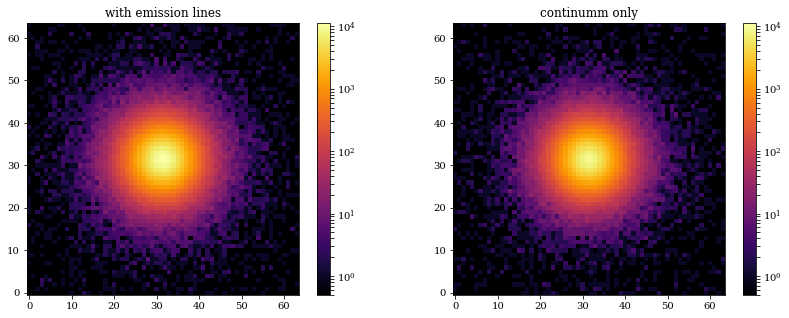

In [25]:
# show the image
data_em = fitsio.read("computesn_em.fits")
data_ne = fitsio.read("computesn_ne.fits")
fig, (ax1, ax2) = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
#ax1.imshow(data_em, interpolation='nearest', cmap='inferno',  origin='lower',norm=LogNorm())
#ax1.set_title('With emission lines')
#ax2.imshow(data_ne, interpolation='nearest', cmap='inferno',  origin='lower',norm=LogNorm())
#ax2.set_title('Without emission lines')

plt.subplot(1, 2, 1).set_title('with emission lines')
plt.imshow(data_em-np.min(data_em)+0.01, interpolation='nearest', cmap='inferno', origin='lower', norm=LogNorm(),
           vmin=0.5, vmax=np.max(data_em))
plt.colorbar()
plt.subplot(1, 2, 2).set_title('continumm only')
plt.imshow(data_ne-np.min(data_em)+0.01, interpolation='nearest', cmap='inferno', origin='lower', norm=LogNorm(),
           vmin=0.5, vmax=np.max(data_em))
plt.colorbar()

# Do the photometry
skynoise = np.sqrt(sky_level_pixel)
flux_em, fluxerr_em, flag_em = sep.sum_circle(data_em, length/2, length/2, gal_r50/pixel_scale*5,
                                              err=skynoise, gain=1.0)
SNR_em = flux_em/fluxerr_em

skynoise = np.sqrt(sky_level_pixel)
flux_ne, fluxerr_ne, flag_ne = sep.sum_circle(data_ne, length/2, length/2, gal_r50/pixel_scale*5,
                                              err=skynoise, gain=1.0)
SNR_ne = flux_ne/fluxerr_ne
flux_ratio = flux_em/flux_ne
delta_mag = 2.5*np.log10(flux_ratio)

print('SNR_em =',SNR_em)
print('SNR_ne =',SNR_ne)
print('flux_em =',flux_em)
print('flux_ne =',flux_ne)
print('flux_ratio =', flux_ratio)
print('delta_mag =', delta_mag)

In [6]:
dwarf_seds = np.load('dwarf_sample_gaussian_test.npy')
dwarf_wave = dwarf_seds['wave'][SED_model]
spec_ne = dwarf_seds['spec_ne'][SED_model]#*10**M_star*10**2/dl**2 #convert flux at 10pc to dl

In [7]:
dwarf_seds = np.load('dwarf_sample_gaussian_test.npy')
dwarf_wave = dwarf_seds['wave'][SED_model]
dwarf_em = dwarf_seds['spec_em'][SED_model]#*10**M_star*10**2/dl**2 #convert flux at 10pc to dl
#print(dwarf_seds.dtype.names)
#print(dwarf_seds['Mag_r'])

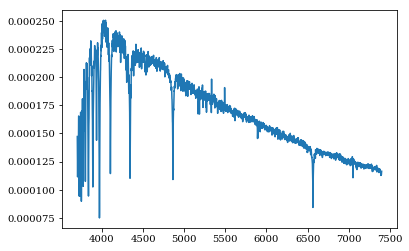

In [8]:
plt.plot(dwarf_wave,spec_ne)
#plt.plot(dwarf_wave,dwarf_em)
#plt.plot(sky_wave,sky_flux)
#plt.plot(x,sed_interp1d,'o')
#plt.xlim(6540,6600)
#plt.ylim(0,0.0012)
plt.show()

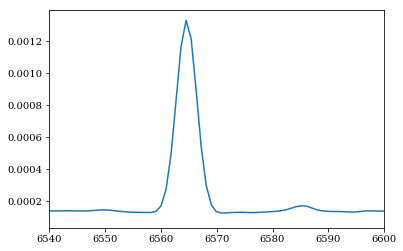

In [9]:
plt.plot(dwarf_wave,dwarf_em)
plt.xlim(6540,6600)
#plt.ylim(0,0.0012)
plt.show()